**VM: Deep Learning mit Python - Model from scratch**

*Group: Leo Giesen, Johannes Kauffmann*

Case Study: Create deep learning model to predict Land Use and Land Cover data drom satellite pictures.

# Imports and Definitions

In [1]:
# Import of packages

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping

import calendar
import os
from google.colab import drive
from packaging import version

assert version.parse(tf.__version__) >= version.parse('2.5.0')

In [2]:
# mount Google drive to get the data

drive.mount('/content/gdrive', force_remount=False)
root_path = 'gdrive/My Drive/Wirtschaftsinformatik/lulc_data'

Mounted at /content/gdrive


In [3]:
# Class names

class_names = {
    0: "No Data", 
    1: "Cultivated Land",
    2: "Forest",
    3: "Grassland",
    4: "Shrubland",
    5: "Water",
    6: "Wetlands",
    7: "Tundra",
    8: "Artificial Surface",
    9: "Bareland",
    10: "Snow and Ice"
}

In [4]:
# Channel names

channel_names = {
    1: "Red",
    2: "Green",
    3: "Blue",
    4: "NIR 1",
    5: "NIR 2",
    6: "NIR 3"
}

In [5]:
color_map = {
    0:  np.array([  0,   0,   0]), #0: "No Data" 
    1:  np.array([240, 218, 173]), #1: "Cultivated Land" 
    2:  np.array([ 33,  87,  18]), #2: "Forest" 
    3:  np.array([153, 196,  61]), #3: "Grassland" 
    4:  np.array([141,  77,  45]), #4: "Shrubland"
    5:  np.array([  0,   5, 247]), #5: "Water"
    6:  np.array([ 95, 250, 253]), #6: "Wetlands"
    7:  np.array([230, 189,  41]), #7: "Tundra" - not present in data
    8:  np.array([236,  48,  29]), #8: "Artificial Surface" 
    9:  np.array([224, 180, 132]), #9: "Bareland" - not present in data
    10: np.array([189, 189, 189]), #10: "Snow and Ice" - not present in data
} 

# Data Loading and Exploration

**Loading data**

In [6]:
data = data = np.load(root_path + '/train.npz')
bands = data['bands'] # data: 10.000 patches, each for twelve months and with six channels. Resolution: 33x33 pixels
lulc = data['lulc'] # labels for central pixel of patches (Land Use and Land Cover)
print(bands.shape)
print(lulc.shape)

(10000, 12, 33, 33, 6)
(10000,)


**Examine data**

In [7]:
#%%script false
# show number of instances per class

count_classes = []
for i in range(11): 
    val = np.count_nonzero(lulc == i)
    print("class "+str(i)+": "+str(val))
    count_classes.append(val)
#print(count_classes)

class 0: 1308
class 1: 238
class 2: 5796
class 3: 1125
class 4: 770
class 5: 58
class 6: 0
class 7: 0
class 8: 217
class 9: 488
class 10: 0


findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


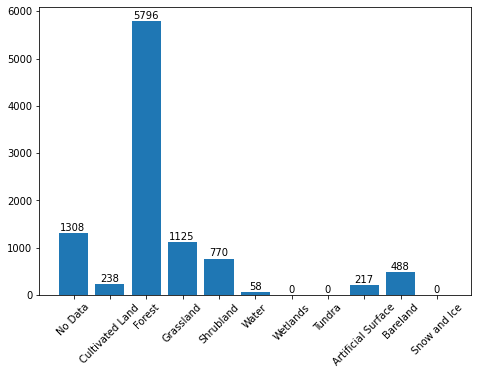

In [8]:
#%%script false

# set the font globally
plt.rcParams.update({'font.family':'serif'})

# print bar chart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = list(class_names.values())
ax.bar(classes,count_classes)
plt.xticks(rotation=45)
for i in range(11):
    val = str(count_classes[i])
    plt.text(
        i - len(val)/11, #X coordinate 
        count_classes[i] + 50, #Y coordinate
        val) #string
plt.show()

--> Realization: Class 2 is over-represented. Classes 6, 7 and 10 are not present in the data set at all.

Channels from patch no. 250
Central pixel is labeled as Cultivated Land


findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


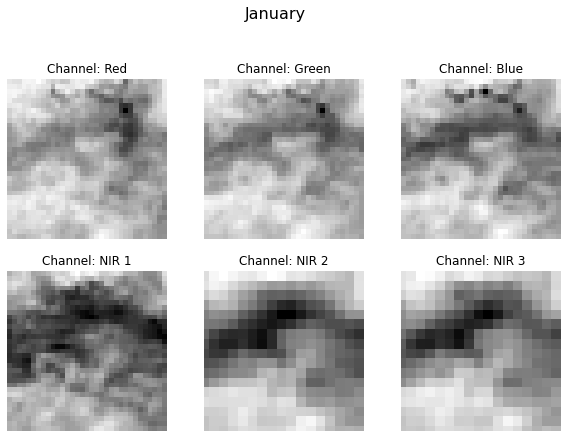

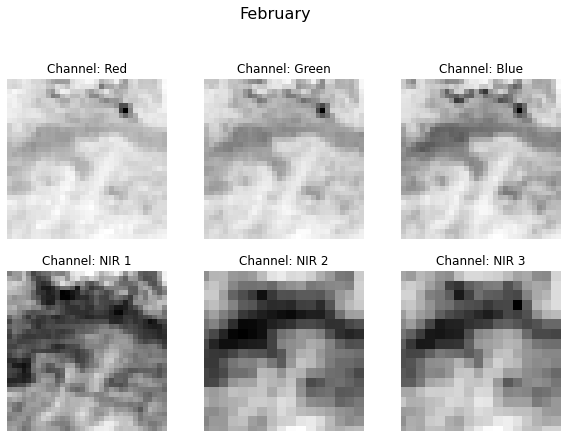

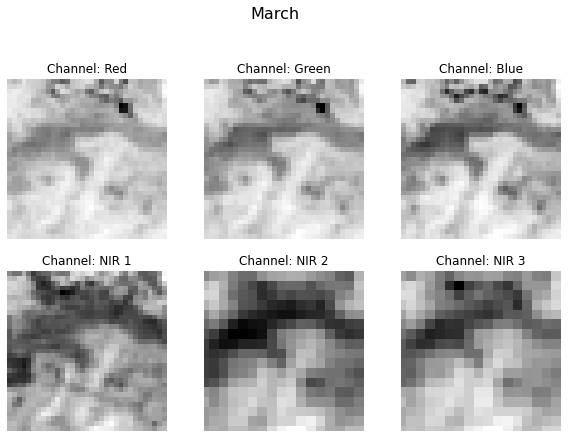

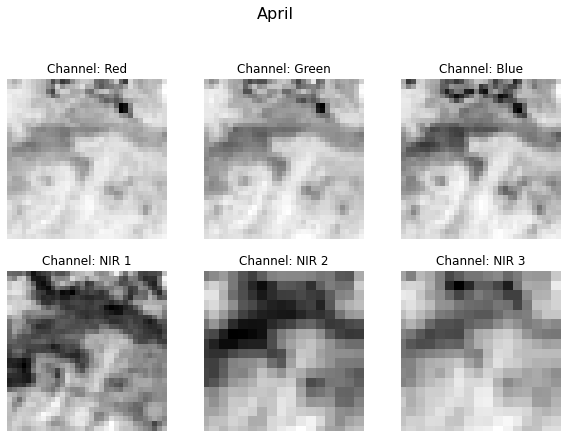

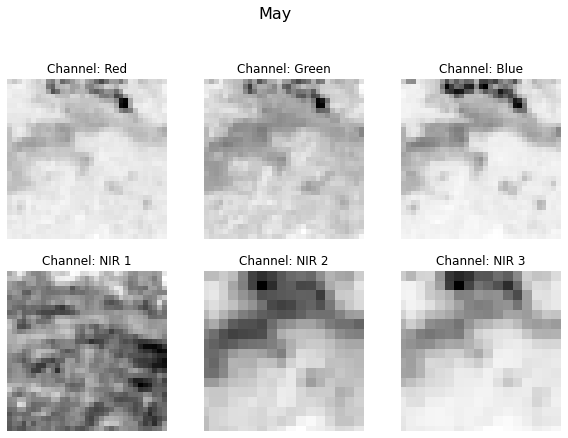

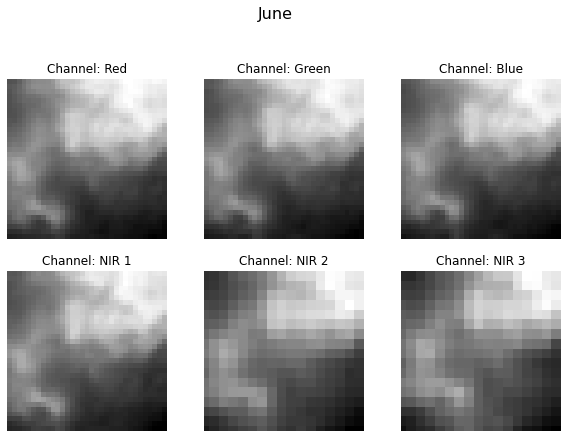

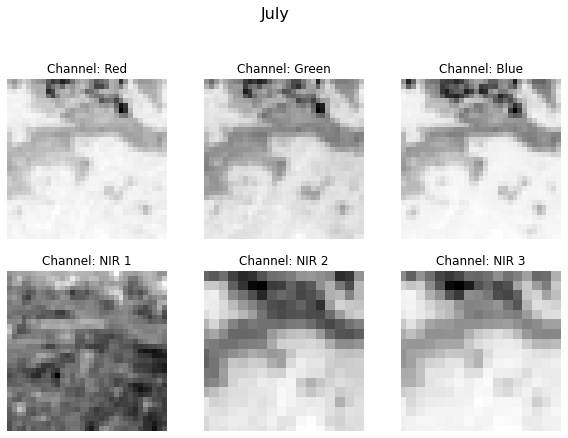

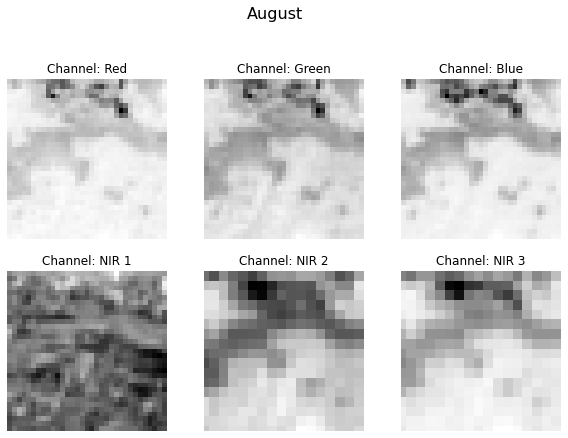

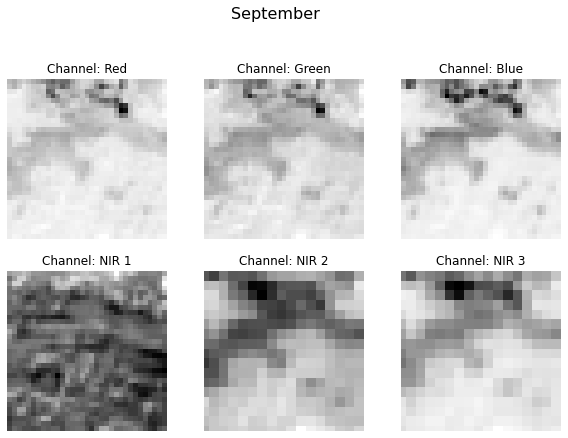

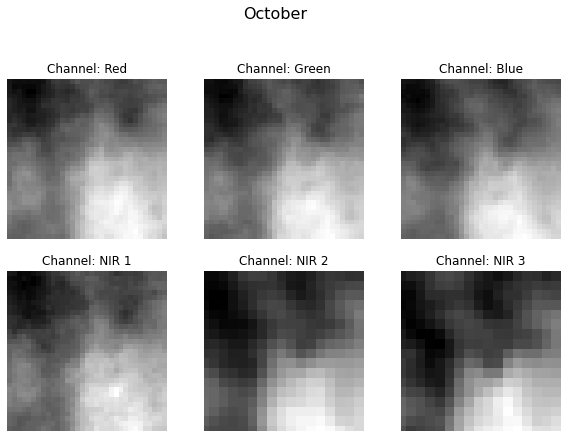

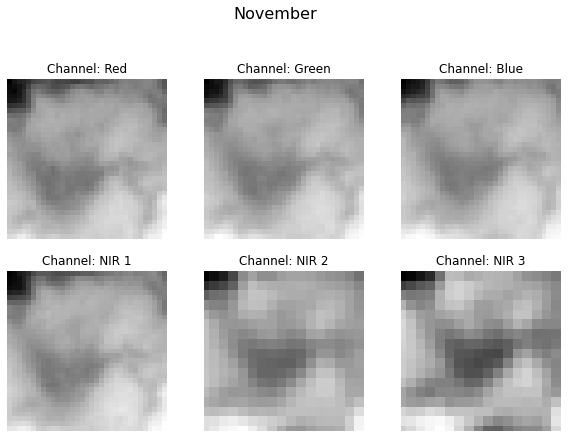

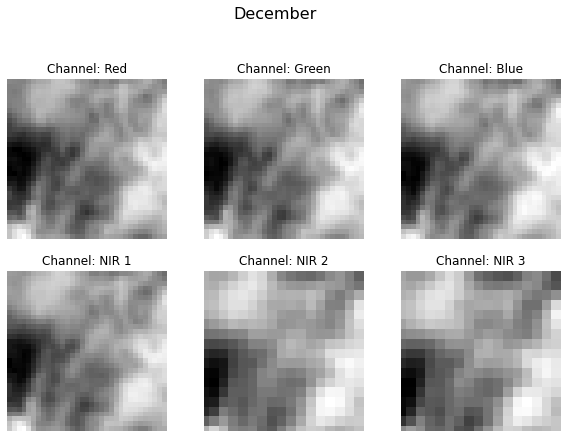

In [9]:
#%%script false
# Show some images

patch = 250 # random patch number

print("Channels from patch no. " + str(patch))
print("Central pixel is labeled as " + class_names[lulc[patch]])

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands[patch, month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

# Data Preparation

**Split data into train, validation and test data**

In [10]:
X = bands
y = lulc

# split into train, test, vaildation sets
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20)
print(X_train.shape)

(6400, 12, 33, 33, 6)


In [11]:
# clear variables to save RAM
del data
del bands
del lulc
del X
del y

**Class weights** 

In [12]:
# Calculate class weights automatically
class_weights_array = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

# Create dictionary for the class weights
class_weights_dict = {
    0: class_weights_array[0],
    1: class_weights_array[1],
    2: class_weights_array[2],
    3: class_weights_array[3],
    4: class_weights_array[4],
    5: class_weights_array[5],
    6: 0,
    7: 0,
    8: class_weights_array[6],
    9: class_weights_array[7],
    10: 0,
}

print(class_weights_dict)

{0: 0.984009840098401, 1: 5.369127516778524, 2: 0.21378941742383753, 3: 1.0781671159029649, 4: 1.6632016632016633, 5: 22.22222222222222, 6: 0, 7: 0, 8: 6.015037593984962, 9: 2.6315789473684212, 10: 0}


**One-hot encoder**

In [13]:
# one-hot encoder for categorical_crossentropy loss to work in model
depth = 11
y_train = tf.one_hot(y_train, depth)
y_val = tf.one_hot(y_val, depth)
y_test = tf.one_hot(y_test, depth)

**Data augmentation**

In [14]:
#%%script false
# Create Tensorflow Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(6400, shape=(), dtype=int64)
tf.Tensor(1600, shape=(), dtype=int64)
tf.Tensor(2000, shape=(), dtype=int64)


In [15]:
# clear variables to have more RAM
del X_train
del y_train
del X_val
del y_val

Code from: [Tensorflow - Data augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [16]:
#%%script false
# create data augmentation layer
data_augmentation_ver = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    #tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

data_augmentation_hor = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    #tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# define prepare function from tensorflow website
def prepare(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set
  if augment:
    import random
    rand = random.uniform(0, 1)
    if rand == 0:
      ds = ds.map(lambda x, y: (data_augmentation_hor(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    else:
      ds = ds.map(lambda x, y: (data_augmentation_ver(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds, shuffle=True)
test_ds = prepare(test_ds, shuffle=True)

print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(200, shape=(), dtype=int64)
tf.Tensor(50, shape=(), dtype=int64)
tf.Tensor(63, shape=(), dtype=int64)


# Choosing a Model

**Build 3D CNN Model from scratch**

In [17]:
base_model = Sequential() # sequential model
base_model.add(Conv3D(32, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(12, 33, 33, 6)))
#base_model.add(Conv3D(32, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='he_uniform', padding='same'))

#base_model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
base_model.add(MaxPooling3D(pool_size=(4, 4, 4)))
base_model.add(BatchNormalization(center=True, scale=True))
base_model.add(Dropout(0.4))
#2
base_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#base_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

base_model.add(BatchNormalization(center=True, scale=True))
base_model.add(Dropout(0.4))
#3
base_model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#base_model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

base_model.add(MaxPooling3D(pool_size=(3, 3, 3)))
base_model.add(BatchNormalization(center=True, scale=True))
#4
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

base_model.add(Dropout(0.4))
base_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

base_model.add(Dropout(0.4))
base_model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))

base_model.add(Dense(11, activation='softmax')) # number of outputs, in our case eleven different classes

In [ ]:
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()

In [18]:
%%script false
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 12, 33, 33, 32)    12320     
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 33, 33, 32)    65568     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 3, 8, 8, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 8, 8, 32)       128       
_________________________________________________________________
dropout (Dropout)            (None, 3, 8, 8, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 8, 8, 64)       55360     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 8, 8, 64)       1

# Training

**Define callbacks**

In [19]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learningrate_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 15)
checkpoint_cb = keras.callbacks.ModelCheckpoint("own_model.h5", save_best_only=True)

**Fitting Model**

In [20]:
%%time
history = base_model.fit(train_ds, epochs=100, batch_size=32, 
                    validation_data=val_ds, callbacks=[checkpoint_cb, early_stopping_cb, learningrate_cb],
                    class_weight=class_weights_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
200/200 [==============================] - 45s 58ms/step - loss: 2.6831 - accuracy: 0.1662 - val_loss: 2.1948 - val_accuracy: 0.1713
Epoch 2/100
200/200 [==============================] - 11s 53ms/step - loss: 2.0401 - accuracy: 0.1870 - val_loss: 1.9697 - val_accuracy: 0.1719
Epoch 3/100
200/200 [==============================] - 11s 53ms/step - loss: 1.7428 - accuracy: 0.1943 - val_loss: 1.6787 - val_accuracy: 0.2237
Epoch 4/100
200/200 [==============================] - 11s 53ms/step - loss: 1.7682 - accuracy: 0.1975 - val_loss: 1.8740 - val_accuracy: 0.1769
Epoch 5/100
200/200 [==============================] - 11s 53ms/step - loss: 1.6758 - accuracy: 0.2212 - val_loss: 2.1573 - val_accuracy: 0.1206
Epoch 6/100
200/200 [==============================] - 11s 53ms/step - loss: 1.6016 - accuracy: 0.2466 - val_loss: 1.7485 - val_accuracy:

# Evaluation

In [21]:
#%%script false
# Calculate loss and accuracy
base_model.evaluate(X_test, y_test)

63/63 [==============================] - 1s 19ms/step - loss: 1.0863 - accuracy: 0.6150


[1.086297869682312, 0.6150000095367432]

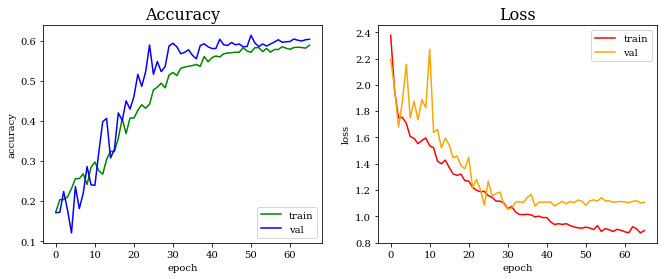

In [32]:
#%%script false
#Plot accuracy and loss of train and val set
plt.rcParams.update({'font.family':'serif'})

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], color="green")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title("Accuracy", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'], color="red",)
plt.plot(history.history['val_loss'], color="orange")
plt.title("Loss", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [37]:
print("accuracy: " + str(history.history['accuracy'][-1]))
print("loss:     " + str(history.history['loss'][-1]))

print("Validation")
print("accuracy: " + str(history.history['val_accuracy'][-1]))
print("loss:     " + str(history.history['val_loss'][-1]))

accuracy: 0.5889062285423279
loss:     0.8912560343742371
Validation
accuracy: 0.6037499904632568
loss:     1.1068974733352661


# Prediction


In [38]:
#%%script false
base_model = keras.models.load_model('gdrive/My Drive/Wirtschaftsinformatik/lulc_data/own_trainingData_210714.h5')

**Testing on Test Set**

In [26]:
data_public_test = np.load(root_path + '/hidden_test.npz') # load test set 
#public_test.npz #for public test set
bands_public_test = data_public_test['bands'] # extract only layer called 'bands'
print(bands_public_test.shape)

(12, 1500, 1500, 6)


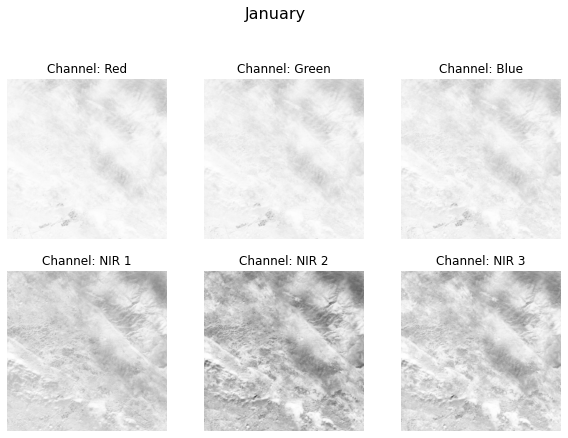

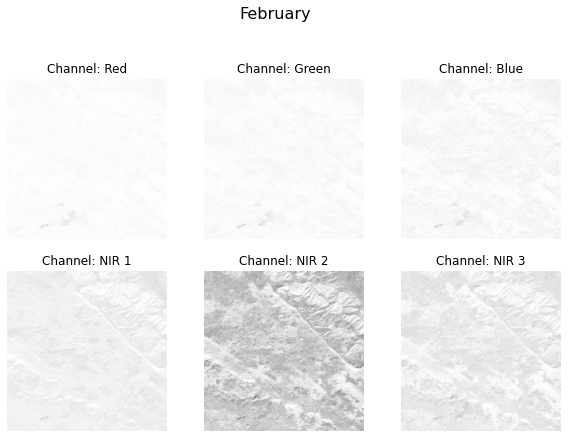

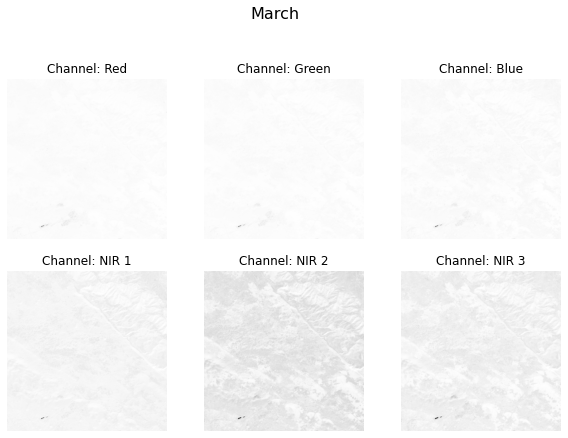

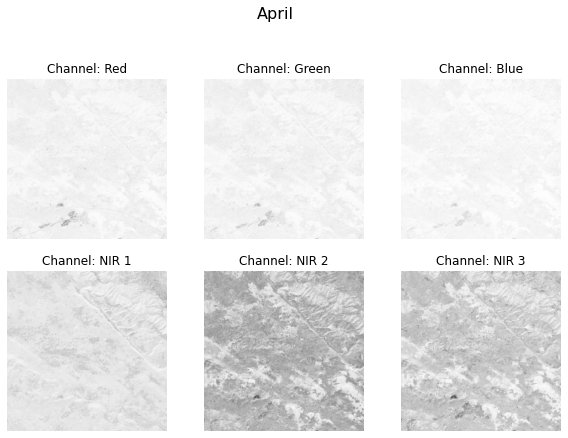

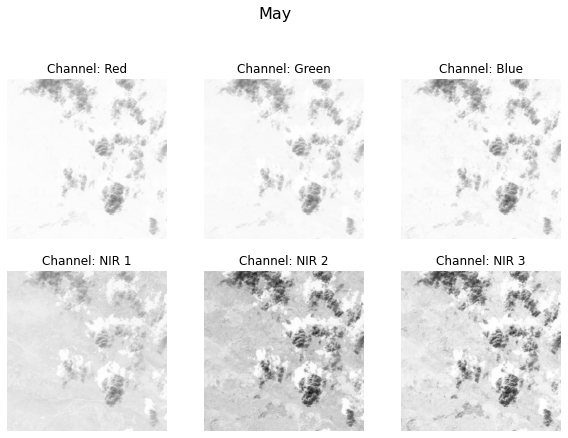

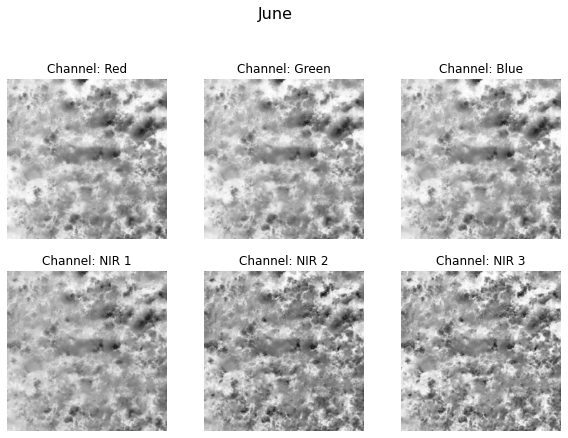

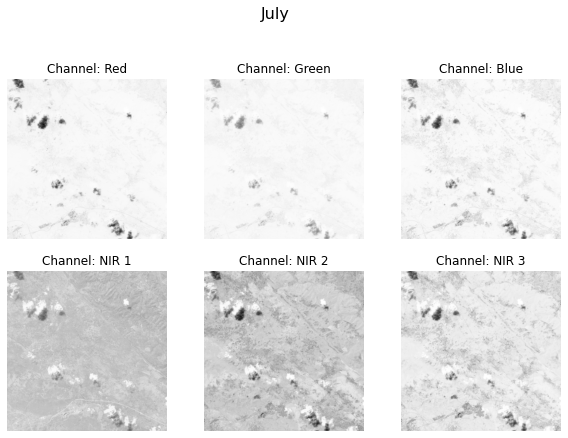

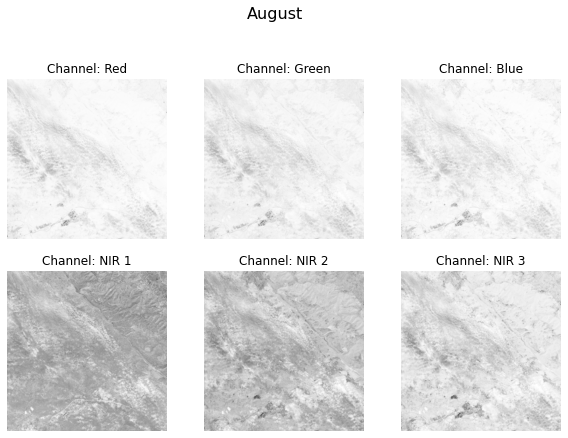

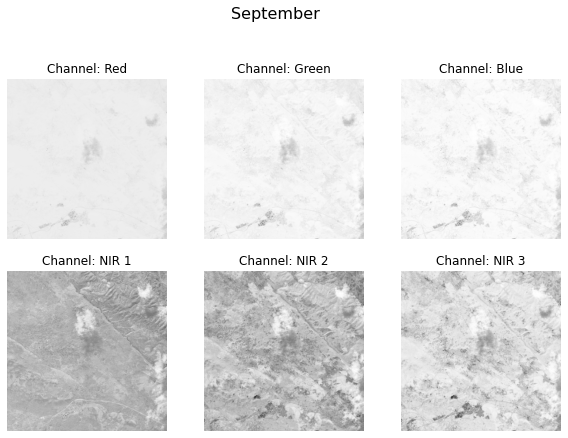

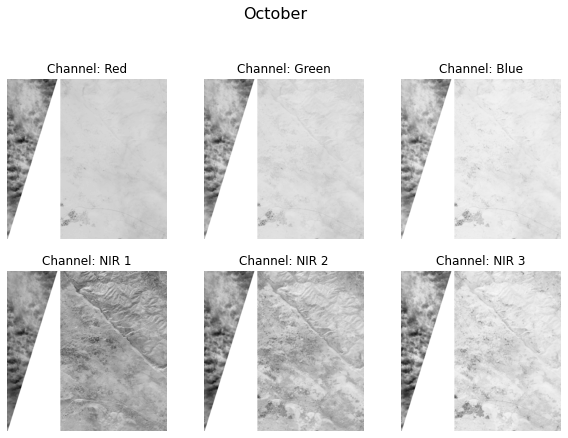

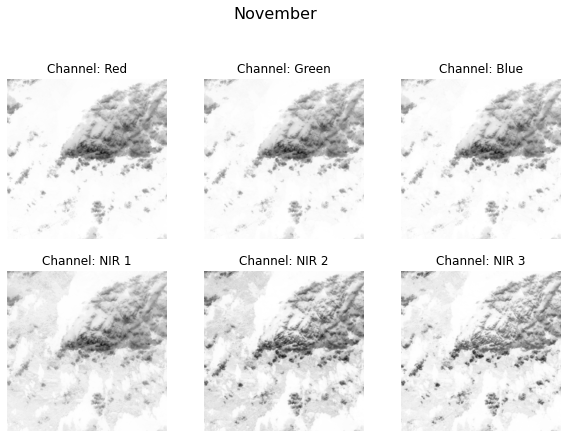

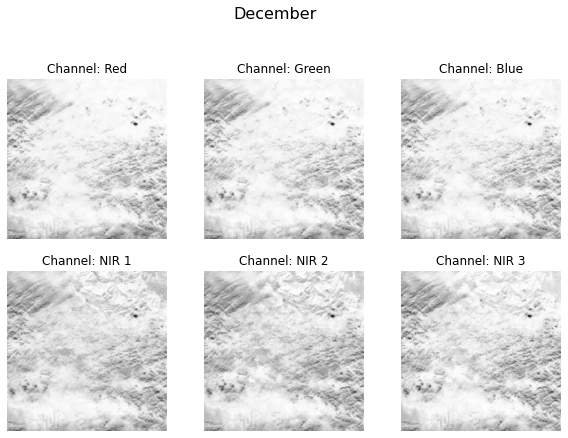

In [27]:
# Show all 12 monthly images of the public test set

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test[month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

**Padding**

To be able to use the sliding window approach on the public test set.

In [28]:
img_size = 1500 #for public set: 500

bands_public_test_pad = np.zeros(shape=(12, img_size + 32, img_size + 32, 6)) # get empty array with correct shape

# perform padding for all images (months and channels)
for month in range(12):
    for channel in range(6):
        bands_public_test_pad[month, :, :,channel] = np.pad(bands_public_test[month, :, :,channel],
                                                            ((16,16),(16,16)), 'constant')
        
print(bands_public_test_pad.shape)

(12, 1532, 1532, 6)


Test padding by printing out the images of the test set.

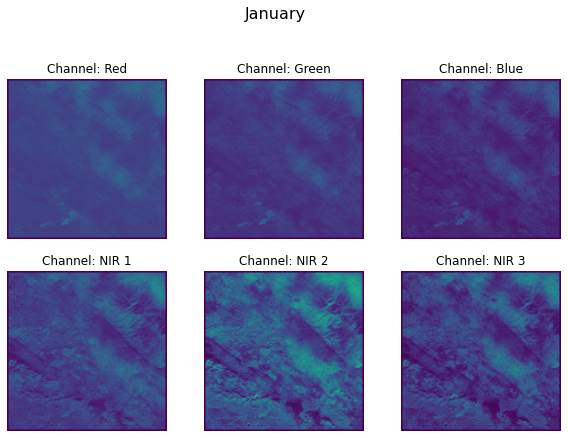

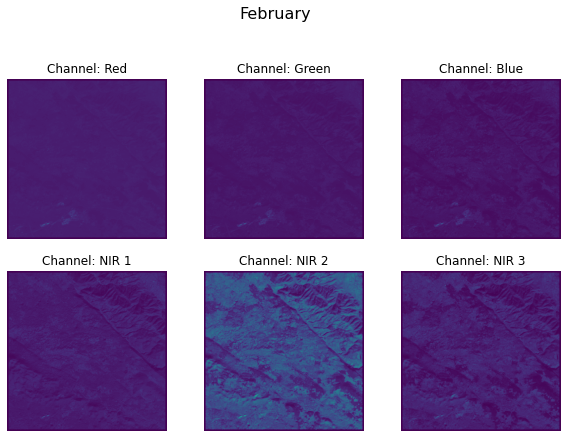

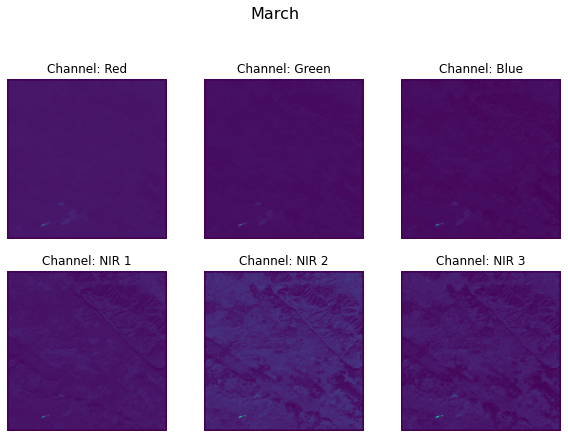

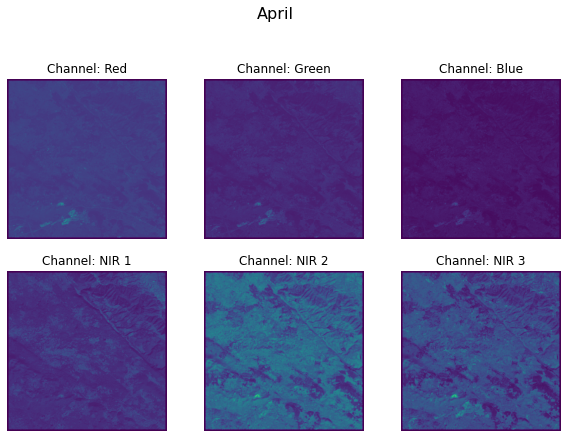

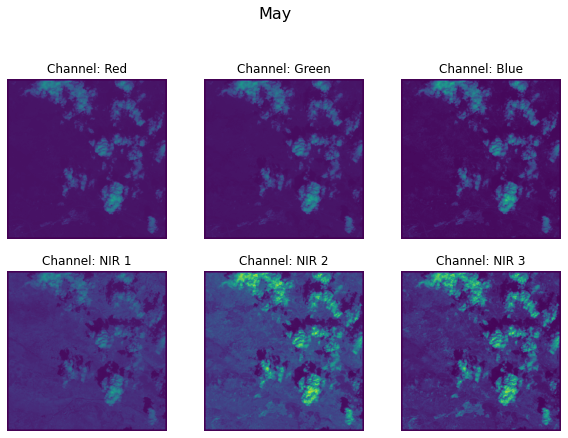

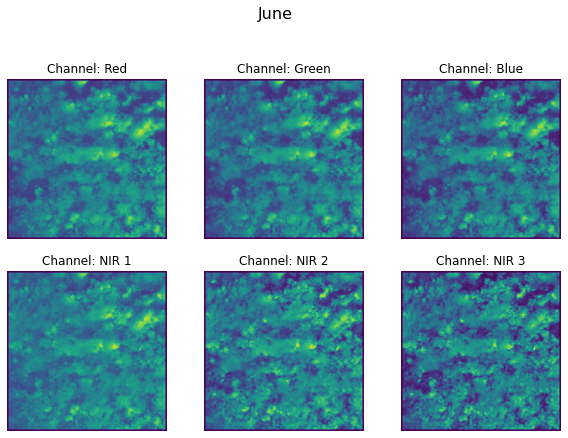

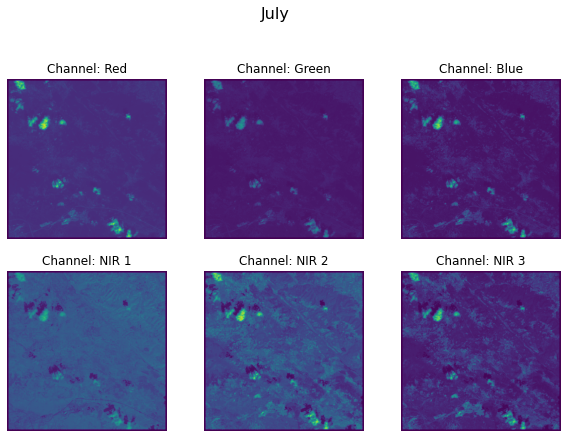

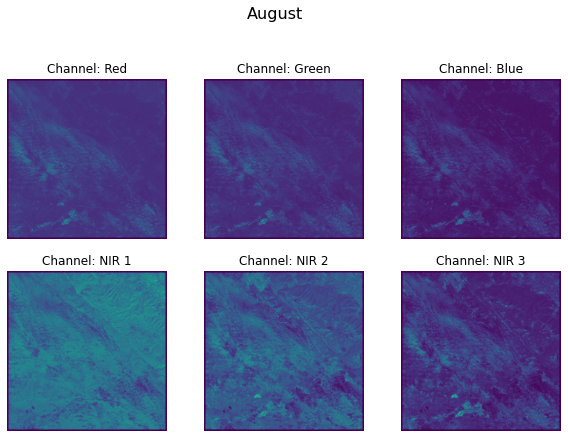

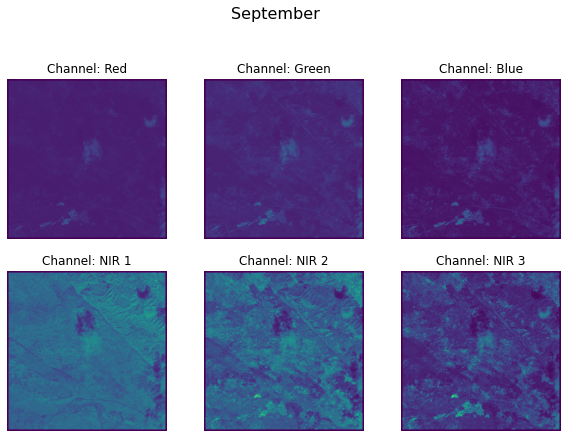

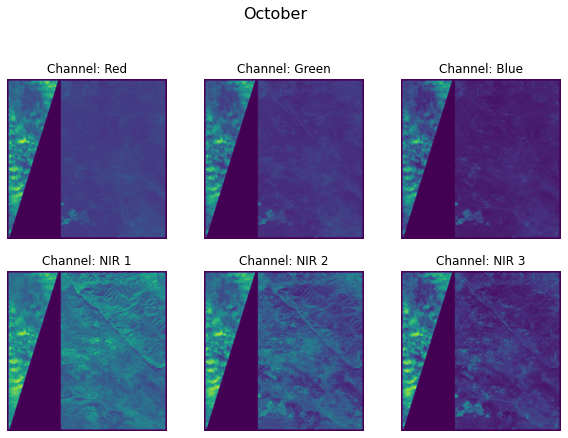

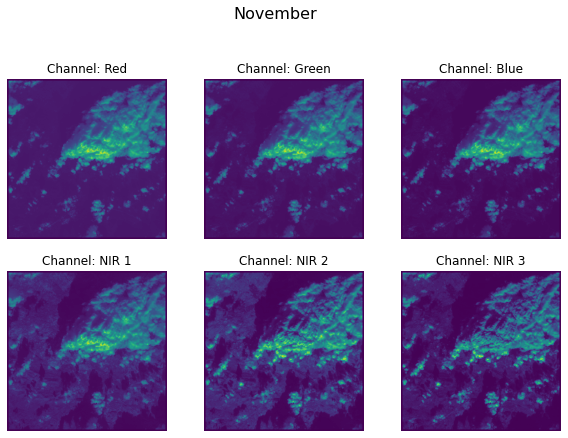

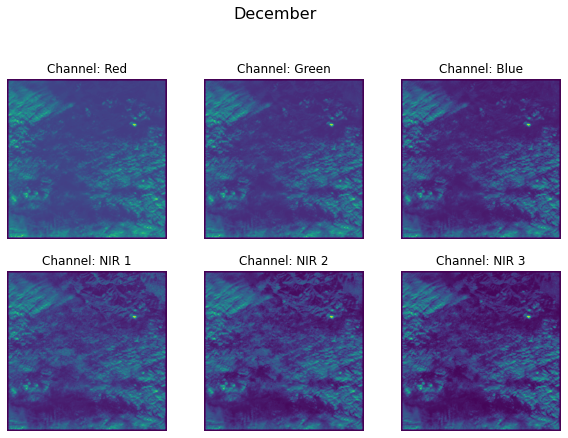

In [29]:
for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test_pad[month, :, :, channel]
        plt.imshow(image)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off") 

In [45]:
# add one dimension to be able feeding our model
bands_public_test_pad = np.expand_dims(bands_public_test_pad, 0)
bands_public_test_pad.shape


y_pred_hidden_complete = np.full((img_size, img_size), 2, dtype=int)
y_pred_hidden_complete.shape

(1500, 1500)

In [39]:
#%%script false
#load progress of prediction
with open("gdrive/My Drive/Wirtschaftsinformatik/lulc_data/y_pred_hidden_1043.npy", "rb") as f:
    #y_pred_hidden = np.load(f)
    y_pred_hidden_complete = np.load(f)

**Naive sliding window approach**

Iterate the model over the whole public test image with stepsize one.

In [70]:
%%time
# Ausschnittskoordinaten für die Prediction definieren
x_coord_start = 1401 #15
end_row = 1468
x_coord_end = x_coord_start + 33

pred_size = (1500 - 33 + 1)

#Zeile zuerst predicted, danach Spalte
for cur_row in range(x_coord_start,end_row):
    # Ausschnittskoordinaten für die nächste Prediction erhöht
    x_coord_end   += 1
    x_coord_start += 1
    y_coord_start = 15
    y_coord_end = y_coord_start + 33
    
    for cur_col in range(pred_size):
        y_coord_end   += 1
        y_coord_start += 1
        
        current_cutout = bands_public_test_pad[:, :, x_coord_start:x_coord_end, y_coord_start:y_coord_end, :]

        y_pred = base_model.predict_classes(current_cutout)

        y_pred_hidden_complete[cur_row][cur_col] = y_pred[0] 
    
    print(
        str(cur_row) + " - " + 
        str(100*cur_row/end_row)+ "% - " + 
        str((end_row-cur_row) * 49.7 / (60*60)) + " h left")
    # Status inkl. completed: 1077-1200 & ab 1416 noch nicht predicted 
    if cur_row % 20 == 0:
      with open("gdrive/My Drive/Wirtschaftsinformatik/lulc_data/y_pred_hidden_complete_" + str(cur_row) + ".npy", "wb") as f:
        np.save(f, y_pred_hidden_complete)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1401 - 95.43596730245231% - 0.9249722222222222 h left
1402 - 95.50408719346049% - 0.9111666666666668 h left
1403 - 95.57220708446866% - 0.8973611111111112 h left
1404 - 95.64032697547684% - 0.8835555555555556 h left
1405 - 95.70844686648502% - 0.8697500000000001 h left
1406 - 95.77656675749319% - 0.8559444444444445 h left
1407 - 95.84468664850137% - 0.842138888888889 h left
1408 - 95.91280653950953% - 0.8283333333333334 h left
1409 - 95.98092643051771% - 0.8145277777777779 h left
1410 - 96.04904632152588% - 0.8007222222222223 h left
1411 - 96.11716621253406% - 0.7869166666666667 h left
1412 - 96.18528610354224% - 0.7731111111111112 h left
1413 - 96.2534059945504% - 0.7593055555555556 h left
1414 - 96.32152588555859% - 0.7455 h left
1415 - 96.38964577656675% - 0.7316944444444445 h left


KeyboardInterrupt: ignored

In [67]:
#%%script false
#load prediction
with open("gdrive/My Drive/Wirtschaftsinformatik/lulc_data/joh_merged.npy", "rb") as f:
    y_pred_hidden = np.load(f)

In [87]:
#expand dimension to match final shape
y_pred_hidden = np.expand_dims(y_pred_hidden_complete, 0)
y_pred_hidden.shape

(1, 1500, 1500)

In [88]:
#save final prediction
filename = "gdrive/My Drive/Wirtschaftsinformatik/lulc_data/y_pred_hidden_complete_2_shape.npy"
with open(filename, "wb") as f:
  np.save(f, y_pred_hidden)
print(filename)

gdrive/My Drive/Wirtschaftsinformatik/lulc_data/y_pred_hidden_complete_2_shape.npy


In [80]:
#%%script false 
#Fill in 2 where our prediction did not predict (because it is the most frequent class)
for row in range(1417, 1469):
  for col in range(pred_size):
    y_pred_hidden_complete[row][col] = 2

**Visualization of the result for the public test set**

Code adapted from https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color

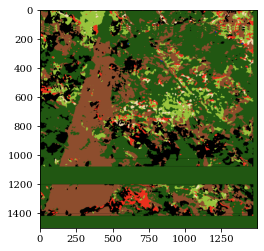

In [81]:
# make a 3d numpy array that has a color channel dimension   
data_3d = np.ndarray(shape=(y_pred_hidden_complete.shape[0], y_pred_hidden_complete.shape[1],3), dtype=int)
for i in range(0, y_pred_hidden_complete.shape[0]):
    for j in range(0, y_pred_hidden_complete.shape[1]):
        data_3d[i][j] = color_map[y_pred_hidden_complete[i,j]]
        #print(str(data_3d[i][j]) + "  -  " + str(y_pred_hidden_complete[i,j]))
# display the plot 
fig, ax = plt.subplots(1,1)
ax.imshow(data_3d)

------

In [ ]:
%%script false
#Dauer prediction für ein Element
%%time
# Ausschnittskoordinaten für die Prediction definieren
x_coord_start = 15 #15
x_coord_end = x_coord_start + 33

pred_size = (1500 - 33 + 1)

for cur_row in range(x_coord_start,16):
    x_coord_end   += 1
    x_coord_start += 1
    y_coord_start = 15
    y_coord_end = y_coord_start + 33
    
    for cur_col in range(1):
        y_coord_end   += 1
        y_coord_start += 1

        current_cutout = bands_public_test_pad[:, :, x_coord_start:x_coord_end, y_coord_start:y_coord_end, :]

        y_pred = base_model.predict_classes(current_cutout)
        y_pred_hidden[cur_row][cur_col] = y_pred[0] 